When searching for networks using AMC, we need to be able to rank discovered-networks by their accuracy.  In reality, we use a multi-objective (such as accuracy and latency) for produce a reward signal to the agent, but we always need to know how well the discovered networks perform their classification task.  We don't need to know the "true Top1" accuracy of the models (the accuracy of the model trained to convergence): we just need to be able to rank them, in a stable manner.  For example, imagine we've discovered two networks in our search: netA and netB.   NetA gives us a low predicted-accuracy signal ("search-Top1"), and NetB gives us a high predicted-accuracy.  If NetA's true-Top1 is smaller than NetB's true-Top1, and this property holds for most pairs of discovered networks, then the ranking is considered stable.

#### Question: 
* Does FM-reconstruction improve the stability of model ranking?

#### Method:
* Use an agent with a random policy, so the RL agent does not play a role. 
* Compare the ranking stability when using FM-reconstruction vs. when using fine-tuning.

#### Baseline:
* L1 ranking with Random agent
* 1 FT epoch

#### Test:
* Reconstruction with Random agent
* 1 FT epoch

In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib 
import csv
from matplotlib.ticker import FuncFormatter
import ipywidgets as widgets
from ipywidgets import interactive, interact, Layout
import matplotlib.pylab as pylab
import matplotlib.animation as animation
from matplotlib import animation, rc
from scipy.stats.stats import pearsonr
from auto_compression_jupyter import *


EXPERIMENTS_DIR = os.path.join("/experiments", "amc")

**Test**

    time python3 ../../classifier_compression/multi-run.py ${AMC_EXP_PATH}/plain20-random-reconstruction_nondeterministic amc.py --arch=plain20_cifar ${CIFAR10_PATH} --resume=${CHECKPOINTS_PATH}/checkpoint.plain20_cifar.pth.tar --lr=0.05 --amc-protocol=mac-constrained --amc-action-range 0.05 1.0 --amc-target-density=0.5 -p=50 --etes=0.075 --amc-ft-epochs=0 --amc-prune-pattern=channels --amc-prune-method=fm-reconstruction --amc-agent-algo=Random-policy --amc-cfg=auto_compression_channels.yaml --evs=0.5 --etrs=0.5 --amc-rllib=random -j=1

==> experiments/plain20-random-reconstruction/2019.07.22-120953/

    time python parallel-finetune.py --scan-dir=${AMC_EXP_PATH}/plain20-random-reconstruction_nondeterministic/2019.07.23-124600 --arch=plain20_cifar --lr=0.005 --vs=0 -p=50 --epochs=60 --compress=../plain20_fine_tune.yaml ${CIFAR10_PATH} -j=1 --deterministic --epoch=1 --output-csv=ft_1epoch_results.csv
    
**Baseline**

    time python3 ../../classifier_compression/multi-run.py ${AMC_EXP_PATH}/plain20-random-l1_rank amc.py --arch=plain20_cifar ${CIFAR10_PATH} --resume=${CHECKPOINTS_PATH}/checkpoint.plain20_cifar.pth.tar --lr=0.05 --amc-protocol=mac-constrained --amc-action-range 0.05 1.0 --amc-target-density=0.5 -p=50 --etes=0.075 --amc-ft-epochs=0 --amc-prune-pattern=channels --amc-prune-method=l1-rank --amc-agent-algo=Random-policy --amc-cfg=auto_compression_channels.yaml --evs=0.5 --etrs=0.5 --amc-rllib=random -j=1

==> classifier_compression/experiments/plain20-random-l1_rank/2019.07.21-004045

    time python parallel-finetune.py --scan-dir=${AMC_EXP_PATH}/plain20-random-l1_rank/2019.07.21-004045/ --arch=plain20_cifar --lr=0.005 --vs=0 -p=50 --epochs=60 --compress=../plain20_fine_tune.yaml ${CIFAR10_PATH} -j=1 --deterministic --epoch=1 --output-csv=ft_1epoch_results.csv

==> classifier_compression/experiments/plain20-random-l1_rank/2019.07.21-004045/ft_1epoch_results.csv

---
#### NOTE

* We use ```multi-run.py``` to execute the experiment 4 times, and write the output of each experiment to a separate subdirectory of ```experiments/plain20-random-l1_rank/2019.07.21-004045```.
* Then we use `parallel-finetune.py` to traverse these subdirectories.
* In each experiement subdirectory there are checkpoints for each of the best discovered networks.  Each time we find a network that performs better than the best network discovered so far (as measured by our multi-objective), we save the checkpoint of that netowrk.
* Script `parallel-finetune.py` will run a fine-tuning (re-training) session of each of the network-checkpoint files and write the accuracy and other metadata of each fine-tuned network to a CSV file.
* So if we execute 4 experiments using `multi-run.py`, then the CSV file should have the results for checkpoints of each of these 4 experiments.

In [23]:
df_baseline = pd.read_csv(os.path.join(EXPERIMENTS_DIR,
                                       "plain20-random-l1_rank",
                                       "2019.07.21-004045",
                                       "ft_1epoch_results.csv"))
df_thesis = pd.read_csv(os.path.join(EXPERIMENTS_DIR,
                                     "plain20-random-reconstruction_nondeterministic",
                                     "2019.07.23-124600",
                                     "ft_1epoch_results.csv"))

#### Answer:

* When using L1-ranking (with no FT during the RL search process) with a Random agent, there is no corralation between the search Top1 accuracy used as reward, and the Top1 after 1 epoch of FT.
* When using FM-reconstruction, search Top1 scores below ~15% show no corralation to the Top1 after 1 epoch of FT, but higher search Top1 scores show much better corralation (to be measured).

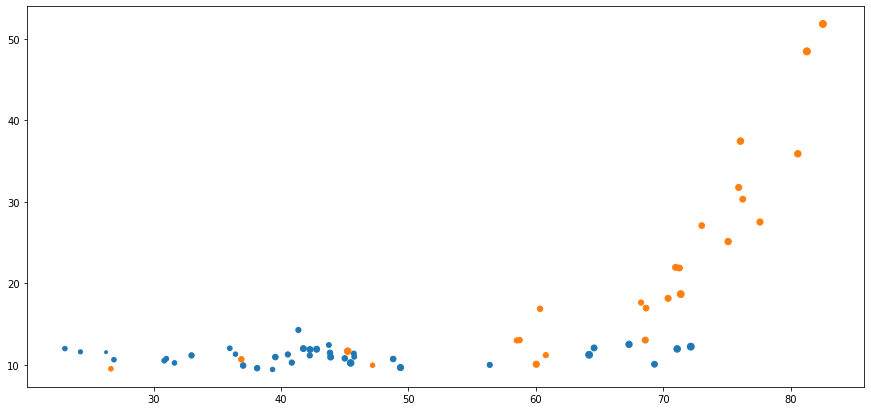

In [24]:
plt.figure(figsize=(15,7))
plt.scatter(df_baseline.top1, df_baseline.search_top1, s=df_baseline.macs)
plt.scatter(df_thesis.top1, df_thesis.search_top1, s=df_thesis.macs)

OK, so clearly performing feature-map reconstruction helps create a much richer reward signal.<br>
But how accurate is this signal?<br>
We take some of the networks from the feature-map reconstruction experiment and fine-tune them for a longer period.


#### Question:
* What happens if we fine-tune the discovered networks for a longer time?<br>
  NOTE: we fine-tune _AFTER_ the RL search is done, so this FT process does not help the agent.  And, in any case, we are using a random agent.
  
<code>
time python parallel-finetune.py --scan-dir=${AMC_EXP_PATH}/plain20-random-reconstruction_nondeterministic/2019.07.23-124600 --arch=plain20_cifar --lr=0.005 --vs=0 -p=50 --epochs=60 --compress=../plain20_fine_tune.yaml ${CIFAR10_PATH} -j=1 --deterministic --epoch=20 --output-csv=ft_20epoch_results.csv
</code>

#### Answer:
* The Pearson corralation **decreases** the more we fine-tune the solution.  This is not good...
* But something interesting happens: the discovered networks that have search-Top1 below ~15% still have low ranking stability (i.e. they do not corrolate well with the "true Top1").

Best network: 82.54
Pearson: 0.753
Best network: 84.65
Pearson: 0.698
Best network: 85.97
Pearson: 0.656
Best network: 87.60
Pearson: 0.594


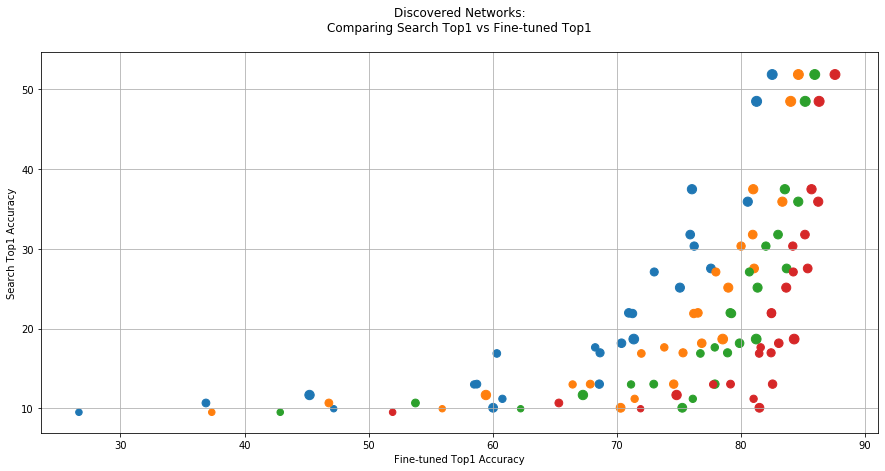

In [37]:
fpath = os.path.join(EXPERIMENTS_DIR, 
                     "plain20-random-reconstruction_nondeterministic",
                     "2019.07.23-124600")
df_thesis3 = pd.read_csv(os.path.join(fpath, "ft_3epoch_results.csv"))
df_thesis6 = pd.read_csv(os.path.join(fpath, "ft_6epoch_results.csv"))
df_thesis20 = pd.read_csv(os.path.join(fpath, "ft_20epoch_results.csv"))

def plot_networks2(df):
    size = df.macs / max(df.macs) * 100
    plt.scatter(df.top1, df.search_top1, s=size)
    print("Best network: %.2f" % max(df.top1))
    df_sorted = df.sort_values(by=['top1'], inplace=False, ascending=False)


create_fig("Discovered Networks:\nComparing Search Top1 vs Fine-tuned Top1\n",
           "Fine-tuned Top1 Accuracy",
           "Search Top1 Accuracy")
for df in (df_thesis, df_thesis3, df_thesis6, df_thesis20):
    plot_networks2(df)
    print("Pearson: %.3f" % pearsonr(df.top1, df.search_top1)[0])


#### Question (Part 2):
What happens when we look at the discovered networks that have a Search Top1 > 20%? <br>
I.e. if we remove the noisy low-grade networks, can we improve the corrallation?

#### Answer (Part 2):
Yes, the corralation increases and we have some evidence of a quality reward signal.  

@todo: compare to the networks trained to **convergence**

In [41]:
create_fig("Discovered Networks:\nComparing Search Top1 vs Fine-tuned Top1\nsearch_top1 > 20%",
           "Fine-tuned Top1 Accuracy",
           "Search Top1 Accuracy")
for df in (df_thesis, df_thesis3, df_thesis6, df_thesis20):
    df = df[df['search_top1'] > 20]
    plot_networks2(df)
    print("Pearson: %.3f" % pearsonr(df.top1, df.search_top1)[0])

Pearson: 0.887
Pearson: 0.905
Pearson: 0.889
Pearson: 0.901


#### Question:

* What happens if we fine-tune the networks we discovered using l1-ranking (without FM reconstruction)?
* In other words, how many fine-tuning epochs do we need to perform during the RL search to get a cleaner, less noisy (i.e. more stable) search-Top1 (used in the multi-objective reward signal)?


    time python parallel-finetune.py --scan-dir=${AMC_EXP_PATH}/plain20-random-l1_rank/2019.07.21-004045/ --arch=plain20_cifar --lr=0.005 --vs=0 -p=50 --epochs=60 --compress=../plain20_fine_tune.yaml ${CIFAR10_PATH} -j=1 --deterministic --epoch=3 --output-csv=ft_3epoch_results.csv

    time python parallel-finetune.py --scan-dir=${AMC_EXP_PATH}/plain20-random-l1_rank/2019.07.21-004045/ --arch=plain20_cifar --lr=0.005 --vs=0 -p=50 --epochs=60 --compress=../plain20_fine_tune.yaml ${CIFAR10_PATH} -j=1 --deterministic --epoch=6 --output-csv=ft_6epoch_results.csv

    time python parallel-finetune.py --scan-dir=${AMC_EXP_PATH}/plain20-random-l1_rank/2019.07.21-004045/ --arch=plain20_cifar --lr=0.005 --vs=0 -p=50 --epochs=60 --compress=../plain20_fine_tune.yaml ${CIFAR10_PATH} -j=1 --deterministic --epoch=20 --output-csv=ft_20epoch_results.csv

#### Answer:

* Fine-tuning longer does not help increase the quality of the search-Top1 accuracy.

Best network: 72.17
Pearson: 0.129
Best network: 81.88
Pearson: 0.137
Best network: 85.47
Pearson: 0.073


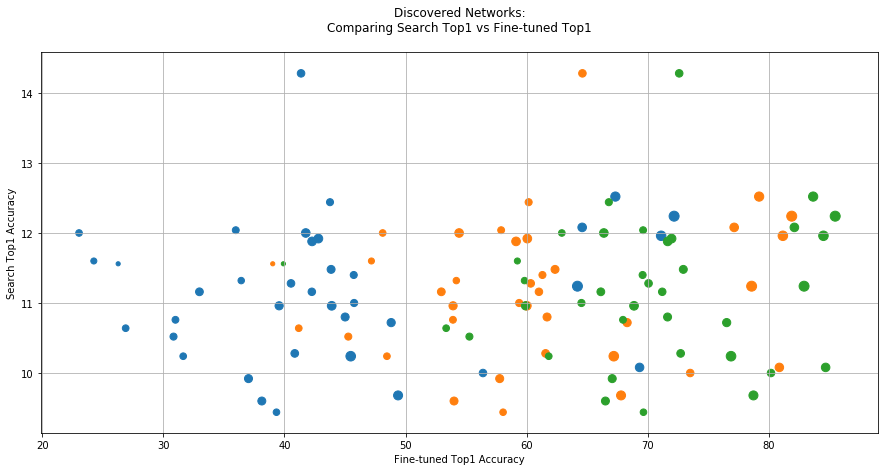

In [45]:
fpath = os.path.join(EXPERIMENTS_DIR, 
                     "plain20-random-l1_rank",
                     "2019.07.21-004045")

df_baseline6 = pd.read_csv(os.path.join(fpath, "ft_6epoch_results.csv"))
df_baseline20 = pd.read_csv(os.path.join(fpath, "ft_20epoch_results.csv"))
#df_baseline60 = pd.read_csv(os.path.join(fpath, "ft_60epoch_results.csv"))

    
create_fig("Discovered Networks:\nComparing Search Top1 vs Fine-tuned Top1\n",
           xlabel="Fine-tuned Top1 Accuracy",
           ylabel="Search Top1 Accuracy")
for df in (df_baseline, df_baseline6, df_baseline20): #, df_baseline60):
    plot_networks2(df)
    print("Pearson: %.3f" % pearsonr(df.top1, df.search_top1)[0])

## What happens when we randomly sample Resnet20 (instead of Plain20) networks?

<code>
time python3 ../../classifier_compression/multi-run.py ${AMC_EXP_PATH}/resnet20-random-reconstruction_nondeterministic amc.py --arch=resnet20_cifar ${CIFAR10_PATH} --resume=../../ssl/checkpoints/checkpoint_trained_dense.pth.tar --lr=0.05 --amc-protocol=mac-constrained --amc-action-range 0.05 1.0 --amc-target-density=0.5 -p=50 --etes=0.075 --amc-ft-epochs=0 --amc-prune-pattern=channels --amc-prune-method=fm-reconstruction --amc-agent-algo=Random-policy --amc-cfg=auto_compression_channels.yaml --evs=0.5 --etrs=0.5 --amc-rllib=random -j=1
</code>


    time python ../../classifier_compression/parallel-finetune.py --scan-dir=${AMC_EXP_PATH}/resnet20-random-reconstruction_nondeterministic/2019.07.31-213149 --arch=resnet20_cifar --lr=0.1 --vs=0 -p=50 --epochs=60 --compress=../plain20_fine_tune.yaml ${CIFAR10_PATH} -j=1 --deterministic --output-csv=ft_60epoch_results.csv --processes=16

We see so many high-scoring networks that we discover randomly!<br>
A (uniform) random policy performs surpisingly well, but the Pearson corralation is not very high. This means that we'll need to sample and fine-tune quite a few of the high-performing search-top1 networks, to find the best performing converged network.

We can also [graph the filter-pruning sensitivity](https://github.com/IntelLabs/distiller/blob/master/jupyter/sensitivity_analysis.ipynb) of ResNet20 vs. Plain20 vs. ResNet50 and see that of the three models, Plain20 is most sensitive to filter pruning, while the other two are quite robust.

Best network: 90.98
Pearson: 0.755


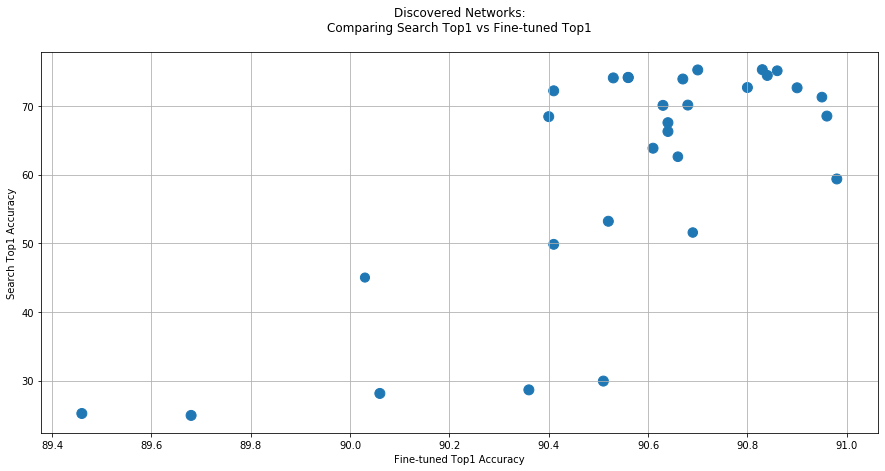

In [48]:
fpath = os.path.join(EXPERIMENTS_DIR, 
                     "resnet20-random-reconstruction_nondeterministic",
                     "2019.07.31-213149")

df_baseline60 = pd.read_csv(os.path.join(fpath, "ft_60epoch_results.csv"))

create_fig("Discovered Networks:\nComparing Search Top1 vs Fine-tuned Top1\n",
           xlabel="Fine-tuned Top1 Accuracy",
           ylabel="Search Top1 Accuracy")
plot_networks2(df_baseline60)
print("Pearson: %.3f" % pearsonr(df_baseline60.top1, df_baseline60.search_top1)[0])
